# Assignment 1

**Handin in Peergrade**: *Monday*, October 14, 2019, 23:59<br>
**Peergrading deadline**: *Friday*, October 18, 2019, 23:59<br>
**Peergrading feedback deadline**: *Sunday*, October 20, 2019, 23:59

[**Feedback**](http://ulfaslak.com/vent)

## Problems

### Week 1

In [2]:
%matplotlib inline

import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

In [3]:
# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q: Print these out, explain their contents. You can instantiate a network by
        # doing `net = Network([2, 3, 1])`, and then printing `net.biases`.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        #net.biases shows the biases of each neuron, the starting neurons do not have biases that is why there are only 4 biases
        #net.weights shows the weight between each neuron there are 6 weight in the first layer and 3 in the second

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
        #loop iterates 2 times 1 iteration for each layer of the neural network past the initial layer

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        # Ulf: For now we just treat this function as a black box.
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            #for every mini_batch update the network's weights and biases by applying gradient descent 
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Ulf: For now we just treat this function as a black box.

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        
        # Ulf: For now we just treat this function as a black box.
        
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y

In [4]:
def prepare_data(X, y):
    """Format the dataset X and y so it fits with Nielsen's code."""
    return [
        (X[i].reshape(-1, 1), y[i].reshape(-1, 1))  # our tuple (x, y)
        for i in range(len(y))
    ]

In [5]:
class cmap_in_range:
    """Create map to range of colors inside given domain.

    Example
    -------
    >>> cmap = cmap_in_range([0, 1])
    >>> cmap(0.1)
    (0.30392156862745101, 0.30315267411304353, 0.98816547208125938, 1.0)
    """
    def __init__(self, cmap_domain, cmap_range=[0, 1], cmap_style='rainbow'):
        self.cmap_domain = cmap_domain
        self.cmap_range = cmap_range
        self.m = interp1d(cmap_domain, cmap_range)
        self.cmap = plt.get_cmap(cmap_style)
        
    def __call__(self, value):
        if not self.cmap_domain[0] <= value <= self.cmap_domain[1]:
            raise Exception("Value must be inside cmap_domain.")
        return self.cmap(self.m(value))

In [6]:
def generate_X_linear(N=200):
    X = np.vstack([
        np.random.normal([-2, -2], 1, size=(int(N/2), 2)),
        np.random.normal([2, 2], 1, size=(int(N/2), 2))
    ])

    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

In [7]:

def generate_X_nonlinear(N=200, R=5):
    X_inner = np.random.normal([0, 0], 1, size=(int(N/2), 2))

    X_outer = np.array([
        [R*np.cos(theta), R*np.sin(theta)]
        for theta in np.linspace(0, 2 * np.pi, int(N/2))
    ]) + np.random.randn(int(N/2), 2)

    X = np.vstack([X_inner, X_outer])
    y = np.array([0] * int(N/2) + [1] * int(N/2)).reshape(-1, 1)
    
    return X, y

> **Ex. 1.2.2**: Create a neural network with `sizes=[2, 1]`. This is actually just our most basic Perceptron model with two inputs and a single output. Generate 1e5 training datapoints and 1e4 testing datapoints using the `generate_X_linear` function, and fit the neural network to this data. Once you've fitted the network, make two plots of your test datapoints, one where points are colored by predictions and another where points are colored by their true labels. Can you say something about the points that are being mislabeled?
>
>*Hint*: You'll probably find some of Nielsen's examples from [Chapter 1](http://neuralnetworksanddeeplearning.com/chap1.html) in his book useful. Also, note that predictions are values between 0 and 1, not hard 0s and 1s, due to the sigmoid activation function. You can deal with this however you like when you color the points by prediction.

## ANS. 1.2.2

In [8]:
Xtr, ytr = generate_X_linear(1e5)
Xte, yte = generate_X_linear(1e4)
net = Network([2, 1])

train = prepare_data(Xtr, ytr)
test = prepare_data(Xte, yte)

In [9]:
net.SGD(training_data=train,epochs=10,mini_batch_size=100,eta=1, test_data=test)

Epoch 0: 9983 / 10000
Epoch 1: 9983 / 10000
Epoch 2: 9982 / 10000
Epoch 3: 9982 / 10000
Epoch 4: 9982 / 10000
Epoch 5: 9982 / 10000
Epoch 6: 9982 / 10000
Epoch 7: 9982 / 10000
Epoch 8: 9982 / 10000
Epoch 9: 9982 / 10000


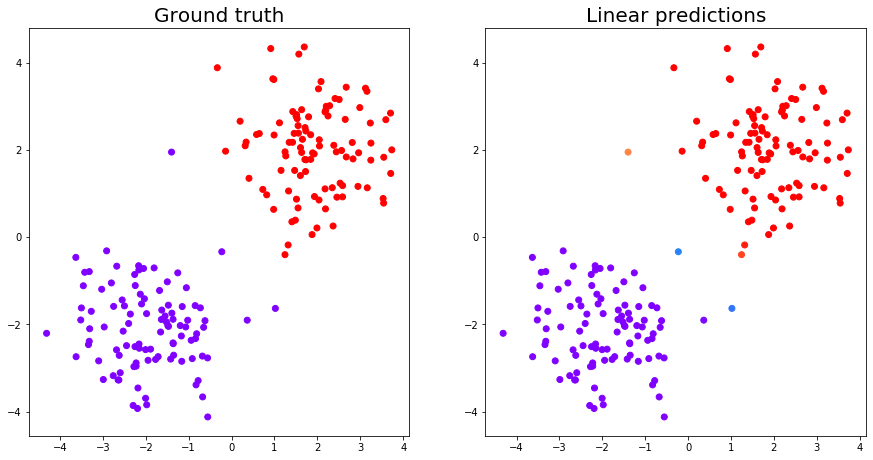

In [10]:
#EDIT THIS

plot_x, plot_y = generate_X_linear()
plot_set = prepare_data(plot_x, plot_y)

preds = np.array([net.feedforward(xy[0]) for xy in plot_set])
preds = np.array([x[0] for x in preds]).flatten()

truths = np.array([xy[1][0] for xy in plot_set])
         
coords = np.array([xy[0] for xy in plot_set])
Xs = [c[0] for c in coords]
Ys = [c[1] for c in coords]

cmap = cmap_in_range([0,1])

plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.scatter(plot_x[:,0], plot_x[:,1], c=[cmap(t) for t in plot_y.flatten()])
plt.title("Ground truth", fontsize=20)

plt.subplot(1,2,2)
plt.scatter(plot_x[:,0], plot_x[:,1], c=[cmap(pred) for pred in preds])
plt.title("Linear predictions", fontsize=20)
plt.show()

> **Ex. 1.2.3**: Now we want to do the same thing as in Ex. 1.2.2, but with the data generated with the `generate_X_nonlinear` function.
>
>*Hint*: Think back to the slides to figure out what `sizes` should be.

## ANS. 1.2.3

In [11]:
net_nonlinear = Network([2,3,1])

Xtr_nonlin, ytr_nonlin = generate_X_nonlinear(1e5)
Xte_nonlin, yte_nonlin = generate_X_nonlinear(1e4)

train_nonlin = prepare_data(Xtr_nonlin, ytr_nonlin)
test_nonlin = prepare_data(Xte_nonlin, yte_nonlin)

In [12]:
net_nonlinear.SGD(training_data=train_nonlin,test_data=test_nonlin,epochs=10,mini_batch_size=100,eta=1)

Epoch 0: 9776 / 10000
Epoch 1: 9757 / 10000
Epoch 2: 9754 / 10000
Epoch 3: 9752 / 10000
Epoch 4: 9751 / 10000
Epoch 5: 9762 / 10000
Epoch 6: 9755 / 10000
Epoch 7: 9761 / 10000
Epoch 8: 9769 / 10000
Epoch 9: 9769 / 10000


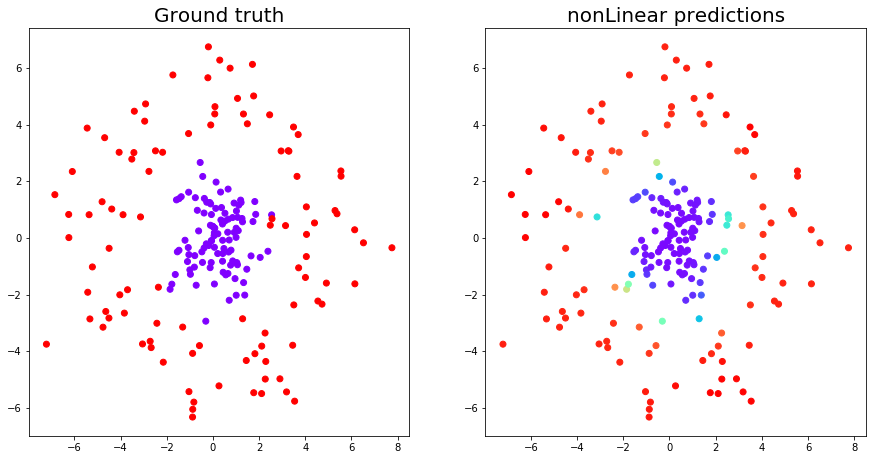

In [13]:
plot_x_nonlin, plot_y_nonlin = generate_X_nonlinear()
plot_set_nonlin = prepare_data(plot_x_nonlin, plot_y_nonlin)

preds = np.array([net_nonlinear.feedforward(xy[0]) for xy in plot_set_nonlin])
preds = np.array([x[0] for x in preds]).flatten()

truths = np.array([xy[1][0] for xy in plot_set_nonlin])
         
coords = np.array([xy[0] for xy in plot_set_nonlin])
Xs = [c[0] for c in coords]
Ys = [c[1] for c in coords]

cmap = cmap_in_range([0,1])

plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.scatter(plot_x_nonlin[:,0], plot_x_nonlin[:,1], c=[cmap(t) for t in plot_y_nonlin.flatten()])
plt.title("Ground truth", fontsize=20)

plt.subplot(1,2,2)
plt.scatter(plot_x_nonlin[:,0], plot_x_nonlin[:,1], c=[cmap(pred) for pred in preds])
plt.title("nonLinear predictions", fontsize=20)
plt.show()

### Week 2

<img src="https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png" alt="drawing" width="500"/>

> **Ex. 2.2.1**: The network above has a defined input and weights. If the true label for the datapoint `[4, 2]` is 1, what is the cost?

> **Ex. 2.2.2**: Knowing about backpropagation, we actually have everything we need to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*

### ANS 2.2.1 & 2.2.2

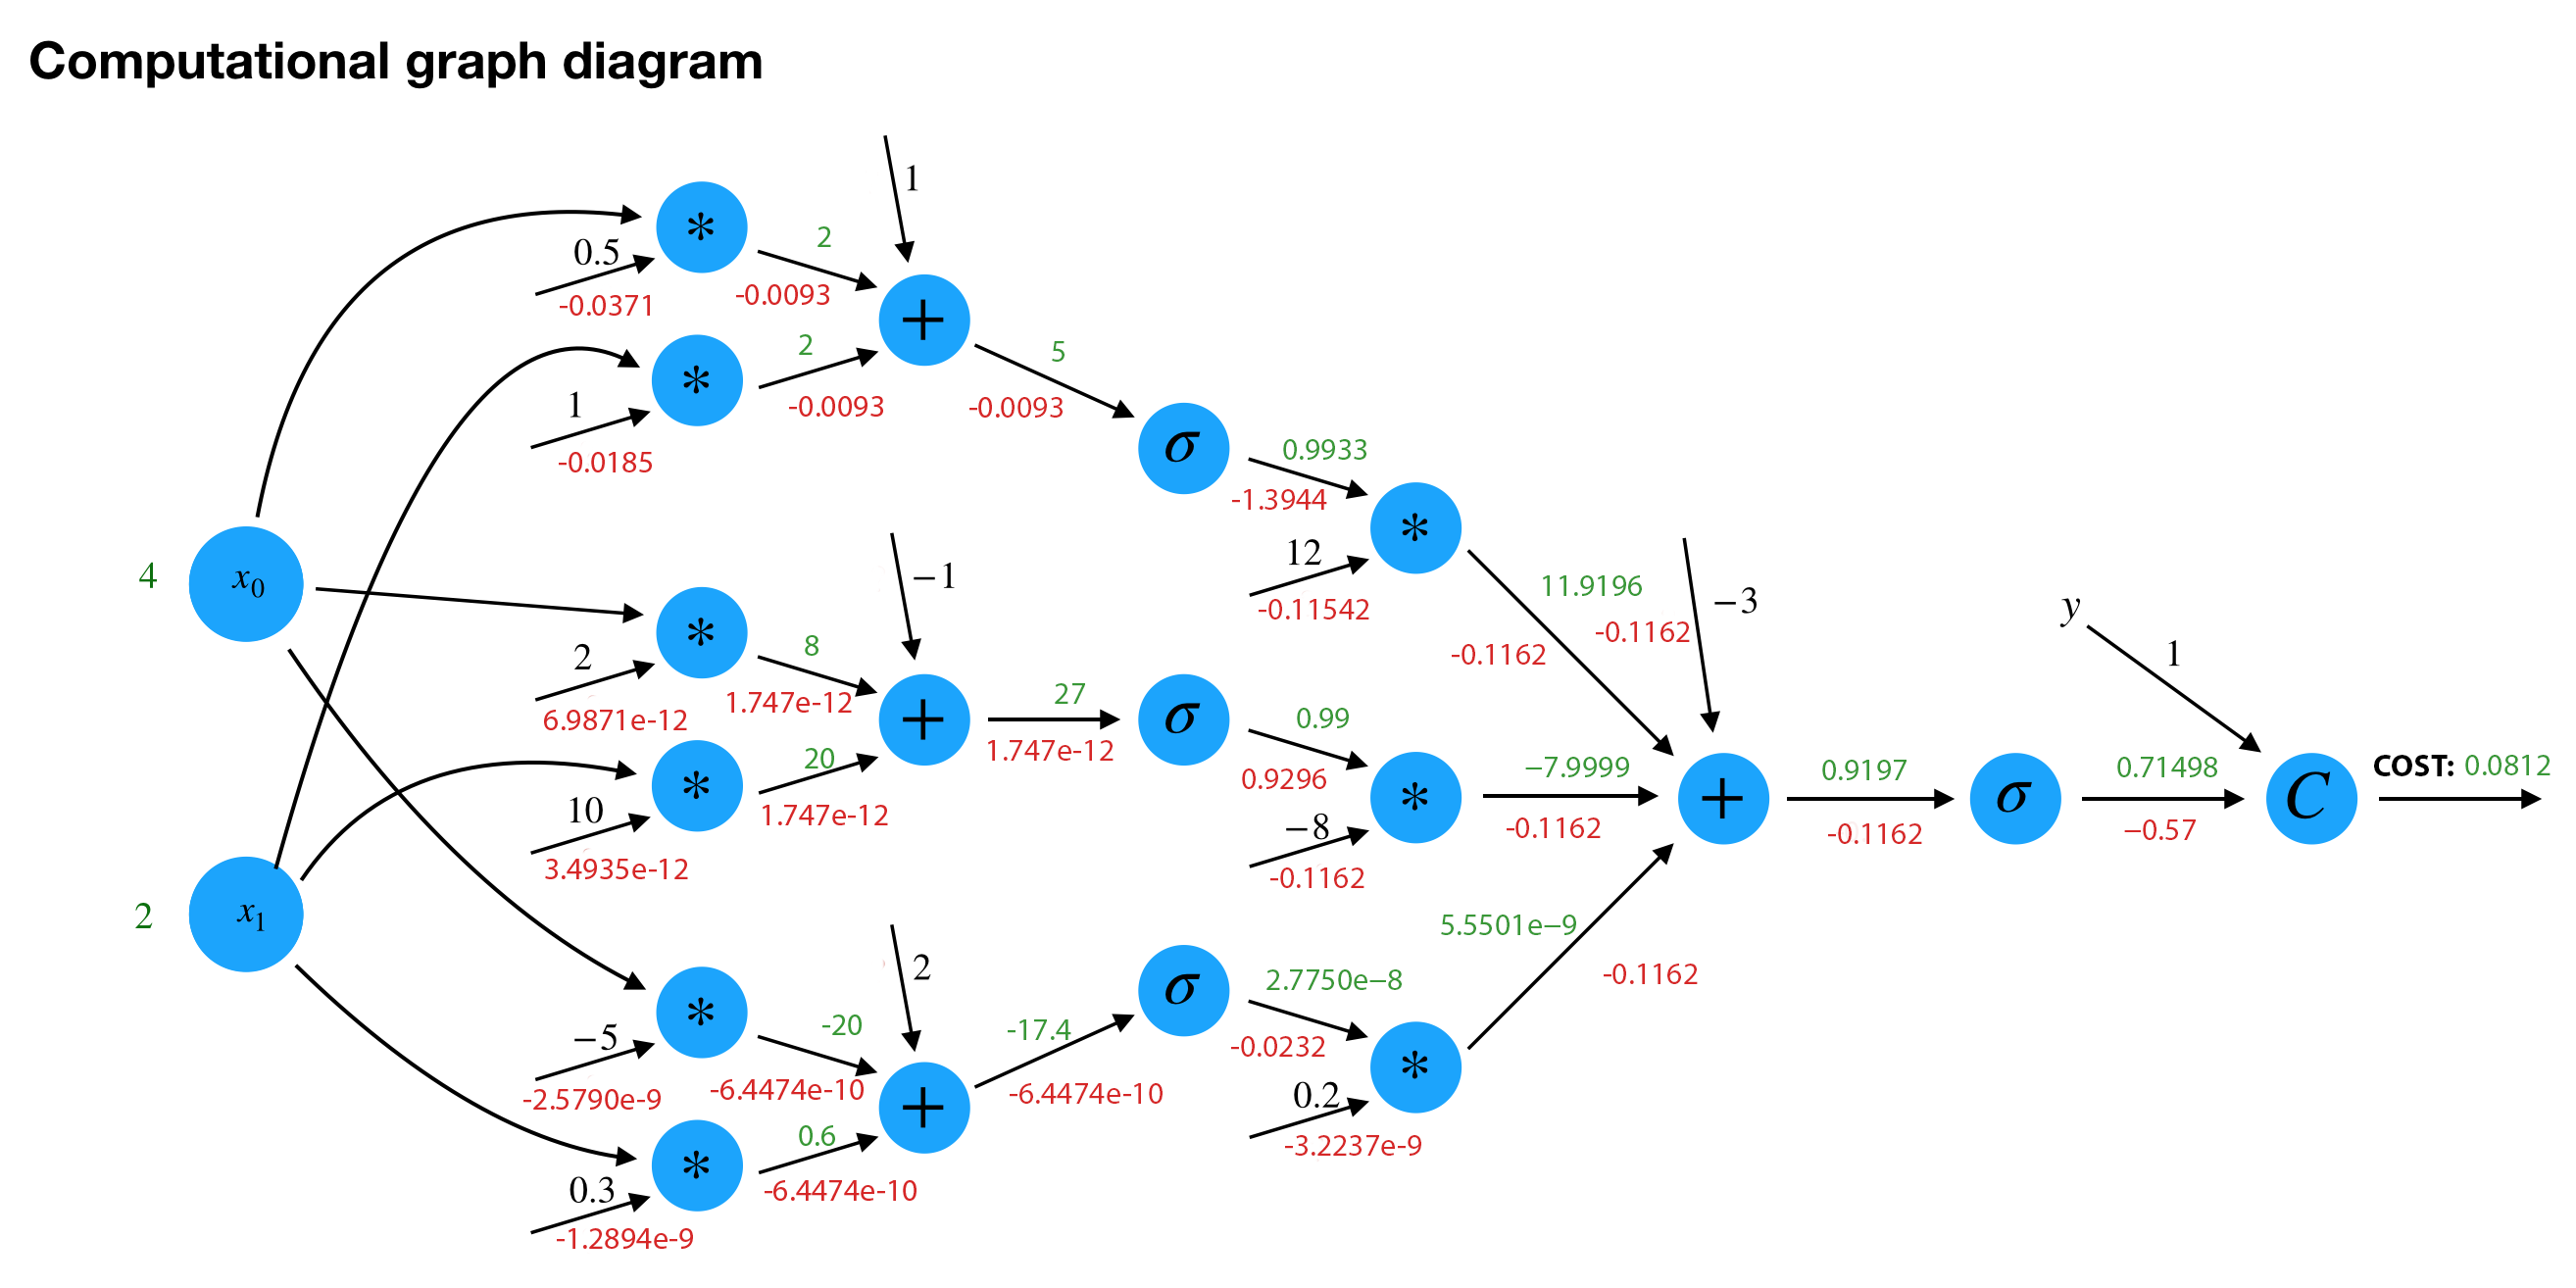

In [1]:
#don't run it or the picture will disappear
from IPython.display import Image
from IPython.core.display import HTML 
PATH = "/Users/alderik/Documents/School/College/DIS/annadl_f19/assignments/"
Image(filename = PATH + "2_3_1_net_compgraph.png", width=1000, height=1000)

### Week 3

> **Ex. 3.1.3** Solve exercises 1.2.2 and 1.2.3 from week 1, but solve them using Keras.
> Comment on differences in speed (and outcome if you observe any).
You can for example use Tensorboard to inspect the training performance throught the training epochs.

### ANS 3.1.3

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import mnist

#3.1.3
x_train, y_train = generate_X_linear(100000)
x_test, y_test = generate_X_linear(10000)

model = Sequential()
model.add(Dense(1, input_dim=2, activation='sigmoid'))
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, verbose= True)
score = model.evaluate(x_test, y_test, verbose=True)

Using TensorFlow backend.


Epoch 1/2
100000/100000 [==============================] - 2s 23us/step - loss: 0.0242 - accuracy: 0.9750
Epoch 2/2
10000/10000 [==============================] - 0s 13us/step


In [16]:
print("accuracy: " + str(score[1]))

accuracy: 0.9973000288009644


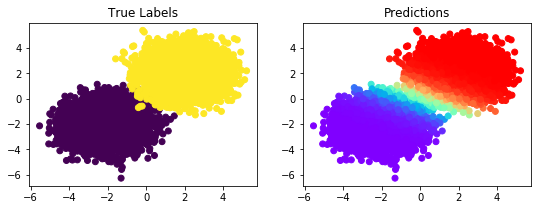

In [17]:

plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("True Labels", fontsize=12)
plt.scatter(x_test[:, 0], x_test[:, 1], c=list(y_test.reshape(-1)))

preds = model.predict(x_test).flatten()
plt.subplot(1, 2, 2)
plt.title("Predictions", fontsize=12)
plt.scatter(x_test[:, 0], x_test[:, 1], c=list(map(cmap_in_range([0,1]), preds)))

plt.show()

In [20]:
Xtr_nonlin, ytr_nonlin = generate_X_nonlinear(1e5)
Xte_nonlin, yte_nonlin = generate_X_nonlinear(1e4)

model = Sequential()
model.add(Dense(3, input_dim=2, activation='sigmoid'))
model.add(Dense(1, input_dim=3, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])
model.fit(Xtr_nonlin, ytr_nonlin, epochs=10, verbose= True)
score = model.evaluate(Xte_nonlin, yte_nonlin, verbose=True)
print(score)

Epoch 1/10
100000/100000 [==============================] - 2s 22us/step - loss: 0.2435 - accuracy: 0.5720
Epoch 2/10
100000/100000 [==============================] - 2s 22us/step - loss: 0.2128 - accuracy: 0.8464
Epoch 3/10
100000/100000 [==============================] - 2s 25us/step - loss: 0.1816 - accuracy: 0.8702
Epoch 4/10
100000/100000 [==============================] - 2s 24us/step - loss: 0.1513 - accuracy: 0.8915
Epoch 5/10
100000/100000 [==============================] - 2s 22us/step - loss: 0.1251 - accuracy: 0.9224
Epoch 6/10
100000/100000 [==============================] - 2s 22us/step - loss: 0.1031 - accuracy: 0.9715
Epoch 7/10
100000/100000 [==============================] - 2s 25us/step - loss: 0.0854 - accuracy: 0.9797
Epoch 8/10
100000/100000 [==============================] - 2s 23us/step - loss: 0.0719 - accuracy: 0.9819
Epoch 9/10
100000/100000 [==============================] - 2s 22us/step - loss: 0.0620 - accuracy: 0.9822
Epoch 10/10
10000/10000 [============

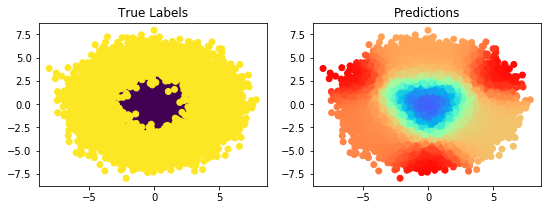

In [21]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.title("True Labels", fontsize=12)
plt.scatter(Xte_nonlin[:, 0], Xte_nonlin[:, 1], c=list(yte_nonlin.reshape(-1)))

preds = model.predict(Xte_nonlin).flatten()
plt.subplot(1, 2, 2)
plt.title("Predictions", fontsize=12)
plt.scatter(Xte_nonlin[:, 0], Xte_nonlin[:, 1], c=list(map(cmap_in_range([0,1]), preds)))

plt.show()

### Comments
Exercise 1.2.2 averages about 2.6 seconds per epoch while repeating the process with keras takes about 2.2 seconds per epoch. Both methods of training the network seem to max out accuracy in the first few epochs. 

Similarly, repeating 1.2.3 with keras is much faster, taking again just over 2.2 seconds per epoch with keras while averaging about 4.7 seconds per epoch in exercise 1.2.3. Accuracy in 1.2.3 seems to max out quickly as in exercise 1.2.2 but with keras accuracy starts low and gradually increases to above 98% by the tenth epoch.

> **Ex. 3.2.1** To understand overfitting, we overfit some data! Let's fit a neural network to data that has no inherent patterns: *noise*.

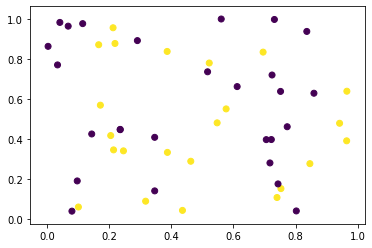

In [22]:
# Generate some data-points
x = np.random.random(size=(50, 2))

# And some random outcomes
y = np.random.randint(0, 2, size=(50, ))

# Plot it
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

> Now, create a network that attains a an accuracy score over 80% in predicting which points are class 0 and which are class 1.
>
> *Hint*: The bigger the network, the bigger the overfitting.

## ANS 3.2.1

In [39]:
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=2))
model.add(Dense(1, activation='sigmoid', input_dim=1000))
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1, momentum=0.1, nesterov=False), metrics=['accuracy'])
model.fit(x, y, epochs=10000, verbose= False)
score = model.evaluate(x, y, verbose=True)

50/50 [==============================] - 0s 324us/step


In [40]:
print(score)

[0.03330908983945847, 0.9800000190734863]


### Week 4

Here's the formula for computing the size of the activation map resulting from a convolution. 
If you have a filter that is $F$ wide, your input image is $W_0$ wide, you are padding the edges by
$P$ pixels and your stride is $S$, the resulting image will have width/height:

$$ W_1 = \frac{W_0 - F + 2P}{S} + 1 $$

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does this immediately cause?
How can we solve it?

### ANS 4.1.2, 4.1.3

#### 4.1.2
$$\frac{28 - 5 + 2(2)}{1} + 1 = 27 + 1 = 28$$

The resulting image is 28 x 28

#### 4.1.3
This causes a width and height that do not divide evenly for the number of shifts of the filter. We can solve this by changing the amount of padding

In the following exercise you will use the MNIST dataset again. In the cell below I have written some code to prepare it somewhat. For your own sake, try to understand what's happening.

In [29]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data so it has a channel dimension
rows, cols = x_train.shape[-2:]
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

# Convert pixel intensities to values between 0 and 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
    
# Convert target vectors to one-hot encoding
num_classes = len(set(y_train))
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

> **Ex. 4.1.5**: Implement Nielsen's [last convolutional neural network](http://neuralnetworksanddeeplearning.com/chap6.html#convolutional_neural_networks_in_practice)
(the one with two convolutional layers and dropout), and score an accuracy higher than 98%. It doesn't have to be
fully identical, but his solution is pretty great, so getting close is a cheap way to score a high accuracy.
>
> *Hint:* [here](https://keras.io/examples/mnist_cnn/) is an example of a CNN in Keras.

### ANS 4.1.5

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',))
model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=1280,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 109s 2ms/step - loss: 0.8637 - accuracy: 0.7327 - val_loss: 0.2307 - val_accuracy: 0.9365
Epoch 2/5
60000/60000 [==============================] - 2014s 34ms/step - loss: 0.2648 - accuracy: 0.9233 - val_loss: 0.1369 - val_accuracy: 0.9580
Epoch 3/5
60000/60000 [==============================] - 92s 2ms/step - loss: 0.1671 - accuracy: 0.9515 - val_loss: 0.0977 - val_accuracy: 0.9694
Epoch 4/5
60000/60000 [==============================] - 89s 1ms/step - loss: 0.1287 - accuracy: 0.9621 - val_loss: 0.0778 - val_accuracy: 0.9747
Epoch 5/5
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1050 - accuracy: 0.9694 - val_loss: 0.0566 - val_accuracy: 0.9812


In [31]:
print("accuracy: " + str(score[1]))

accuracy: 0.9811999797821045
